<h1><center>Inventory Management with Association Rule Mining</center></h1>

<h3>Develop a data-driven approach to optimize the warehouse layout by leveraging Association Rule mining</h3> 

The anonymized dataset includes 64.682 transactions of 5.242 SKU's sold to 22.625 customers during one year<br>
Dataset Description:

    Date of Sales Transaction
    Customer ID
    Transaction ID
    SKU Category ID
    SKU ID
    Quantity Sold
    Sales Amount (Unit price times quantity. For unit price, please divide Sales Amount by Quantity)

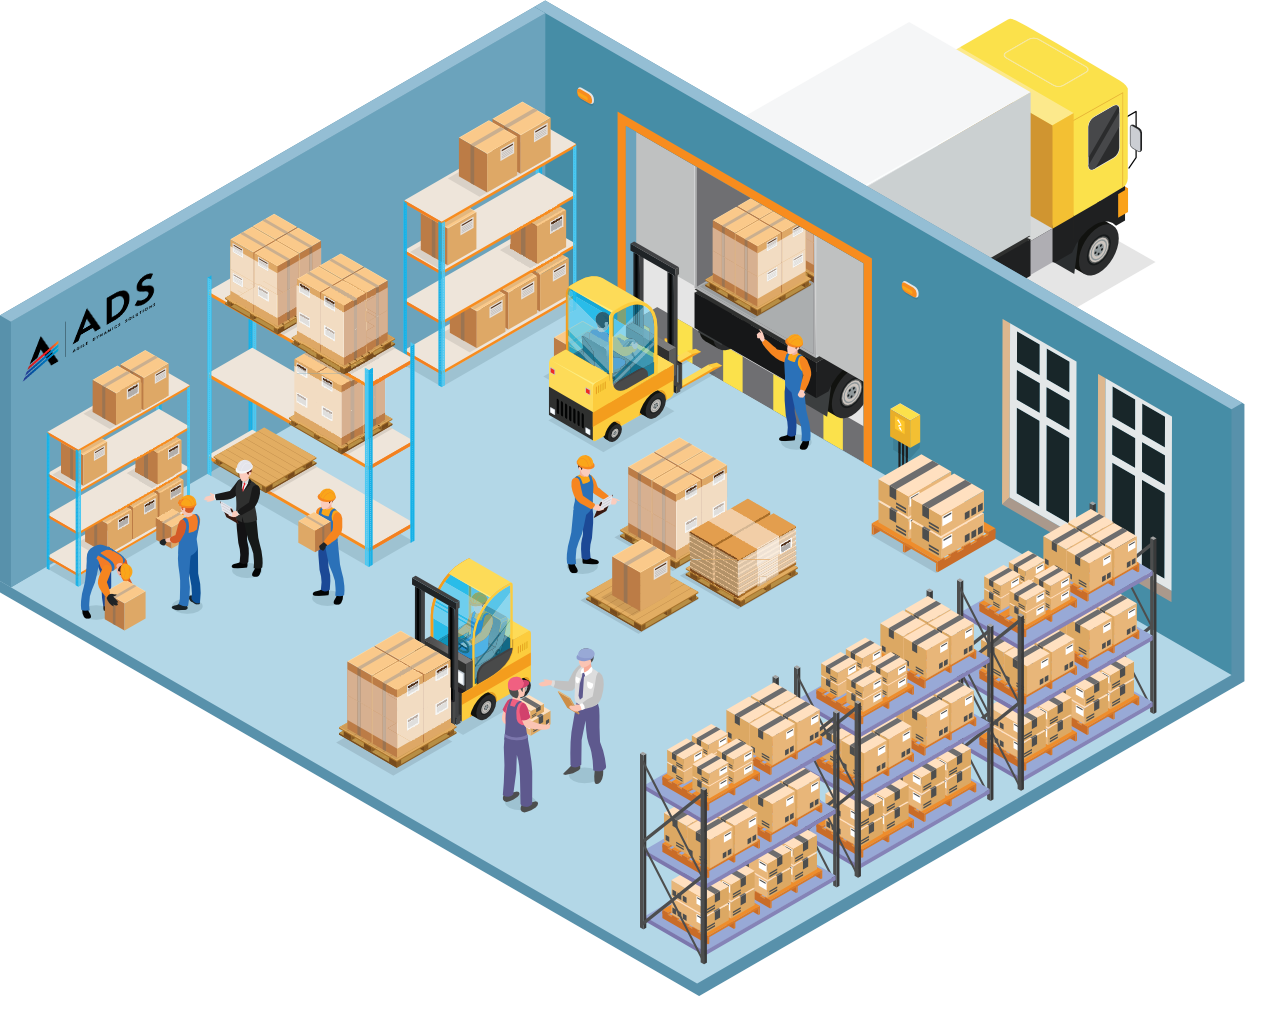

In [58]:
#Importing relevant packages
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

import re
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [59]:
#Reading the dataset
data = pd.read_csv(r"C:\Users\Viren Pai\OneDrive\Desktop\360DigiTMG\DataScience_Assignments\Mod3c.Association Rules_problemstatement\archive\scanner_data.csv", infer_datetime_format = True)

In [60]:
#shape of the dataset
data.shape

(131706, 8)

In [61]:
#Sample records of the dataset
data.sample(5)

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
93918,93919,12/10/2016,9745,49597,P42,OV1P9,1.0,7.43
125384,125385,22/12/2016,15883,63329,0H2,PUT4X,1.0,7.77
42412,42413,30/04/2016,21196,20928,29A,YXM33,1.0,13.38
113708,113709,29/11/2016,22115,58346,D6J,7J2DT,1.0,61.28
8056,8057,25/01/2016,5357,3872,8HU,HT9WP,2.0,28.74


In [62]:
#dropping first column which is redundant
data.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [63]:
#Datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Date            131706 non-null  object 
 1   Customer_ID     131706 non-null  int64  
 2   Transaction_ID  131706 non-null  int64  
 3   SKU_Category    131706 non-null  object 
 4   SKU             131706 non-null  object 
 5   Quantity        131706 non-null  float64
 6   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 7.0+ MB


In [64]:
#Missing value %
data.isna().mean() * 100

Date              0.0
Customer_ID       0.0
Transaction_ID    0.0
SKU_Category      0.0
SKU               0.0
Quantity          0.0
Sales_Amount      0.0
dtype: float64

In [65]:
#Checking for Duplicate rows
data.duplicated().sum()

#No duplicate records

0

In [66]:
#Stats of numerical features
data.nunique()

Date                363
Customer_ID       22625
Transaction_ID    64682
SKU_Category        187
SKU                5242
Quantity             83
Sales_Amount       3233
dtype: int64

In [67]:
#Convering 'Customer_ID' and 'Transaction_ID' into strings
data['Customer_ID'] = data.Customer_ID.astype('str')
data['Transaction_ID'] = data.Transaction_ID.astype('str')

In [68]:
#Stats of numerical features
data.describe()

,Quantity,Sales_Amount
count,131706.000000,131706.000000
mean,1.485311,11.981524
std,3.872667,19.359699
min,0.010000,0.020000
25%,1.000000,4.230000
50%,1.000000,6.920000
75%,1.000000,12.330000
max,400.000000,707.730000


In [69]:
#Converting to date-type
data['Date'] = pd.to_datetime(data['Date'], format = "%d/%m/%Y")

In [70]:
#Stats of categorical variables
data.select_dtypes(['object']).describe()

,Customer_ID,Transaction_ID,SKU_Category,SKU
count,131706,131706,131706,131706
unique,22625,64682,187,5242
top,1660,1348,N8U,UNJKW
freq,228,21,10913,2007


In [71]:
data.sort_values(by = 'Date', inplace = True)

In [72]:
data['month'] = data.Date.dt.month
data['month_name'] = data.Date.dt.month_name().str[:3]

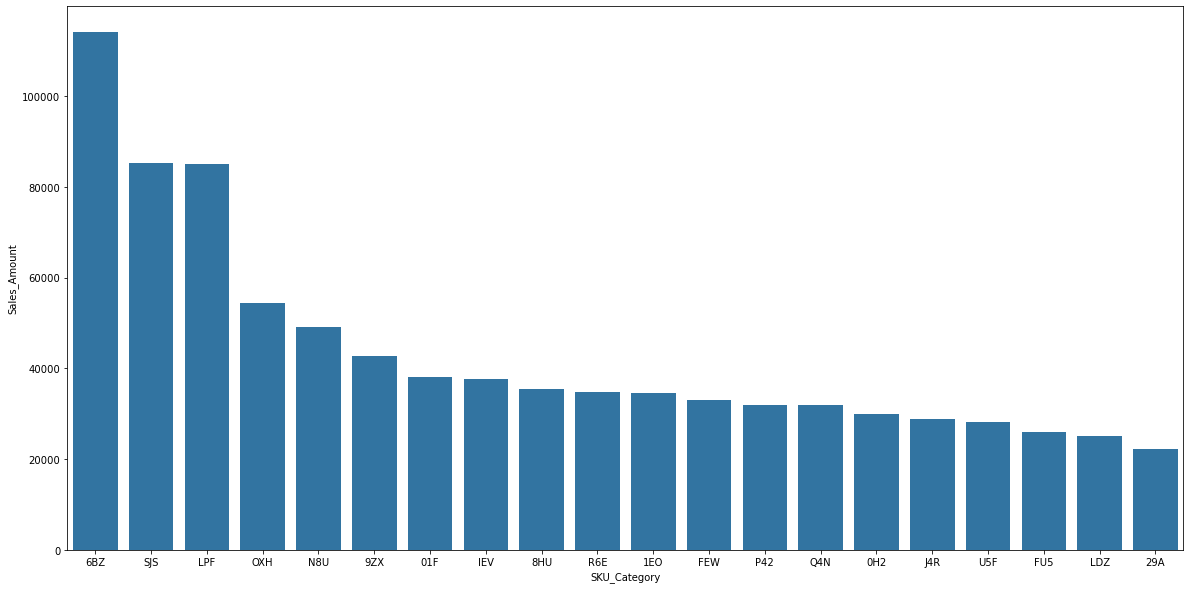

In [88]:
#Sales figures by 'SKU_Category': top 20
sales_top20 = data.groupby(['SKU_Category']).Sales_Amount.sum().sort_values(ascending = False).head(20)

plt.figure(figsize = (20, 10))
sns.barplot(sales_top20)
plt.show()

In [74]:
#Two dictionaries needed for Transactional Encoding
#1. Transaction_ID : SKU_Category
#2. Transaction_ID : SKU

In [75]:
#Identifying transactions with count of unique SKU category
SKU_count = data.loc[:,['Transaction_ID', 'SKU_Category']].groupby(['Transaction_ID']).SKU_Category.nunique() \
                .reset_index().sort_values(by = ['SKU_Category'], ascending = False)

In [76]:
SKU_count.columns = ['Transaction_ID', 'Unique_SKU_count']

In [77]:
SKU_count[SKU_count.Unique_SKU_count > 1]
#28996 transactions identified with more than 1 unique SKU's
#About 56% of the transactions are filtered out

,Transaction_ID,Unique_SKU_count
34868,4138,17
62200,7765,16
26625,33961,16
20814,28731,15
24235,3181,15
...,...,...
60878,6575,2
20680,28610,2
21155,29038,2
52925,57631,2


In [78]:
#List of 'Transaction_ID' with SKU count > 1
SKU_list = list(SKU_count[SKU_count.Unique_SKU_count > 1]['Transaction_ID'].values)

In [79]:
#Dictionary with 'Transaction_ID' as keys and unique SKUs as values
trans_dict = {}
trans_SKU = data.loc[:,['Transaction_ID', 'SKU_Category']]

for sku in SKU_list:
    vals = list(trans_SKU[trans_SKU.Transaction_ID == sku]['SKU_Category'].unique())
    trans_dict[sku] = vals

In [176]:
#List of SKU's in transaction id '4138'
print(trans_dict['4138'])

['U5F', '8HU', 'LPF', 'D6J', 'GGP', '6BZ', 'A38', 'SJS', 'EKM', '01F', '69K', 'OQA', 'J4R', 'JB0', 'Q4N', 'LDZ', 'OXH']


#### Association Rule Mining

In [80]:
#Importing relevant packages
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [146]:
#Fitting transaction encoder
te_ = TransactionEncoder()
te_.fit(pd.Series(trans_dict.values()))

TransactionEncoder()

In [147]:
te_df = pd.DataFrame(te_.transform(pd.Series(trans_dict.values())), columns = te_.columns_, index = trans_dict.keys())
te_df.shape

(28996, 184)

In [172]:
te_df

,01F,06Z,0H2,0KX,0WT,10Y,144,1EO,1L6,1R3,...,XVK,XX1,XZC,YMJ,Z23,Z4O,Z99,ZJG,ZX5,ZYU
4138,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7765,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
33961,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
28731,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3181,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6575,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28610,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29038,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
57631,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [161]:
#Apriori algorithm, setting min_support criteria = 0.075
frequent_itemsets = apriori(te_df, min_support = 0.0075, max_len = 2, use_colnames = True)
frequent_itemsets

,support,itemsets
0,0.056766,(01F)
1,0.090219,(0H2)
2,0.008760,(0KX)
3,0.013829,(0WT)
4,0.023452,(1EO)
...,...,...
168,0.015347,"(U5F, OXH)"
169,0.010795,"(P42, R6E)"
170,0.009657,"(P42, YMJ)"
171,0.009519,"(R6E, Q4N)"


In [162]:
#List of pairs with high lift ratio
rules = association_rules(frequent_itemsets, metric = "lift", min_threshold = 1)
rules.sort_values(by = ['lift'], ascending = False, inplace = True)

In [163]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
26,(1VL),(RML),0.051731,0.013864,0.009208,0.178000,12.839025,0.008491,1.199679,0.972417
27,(RML),(1VL),0.013864,0.051731,0.009208,0.664179,12.839025,0.008491,2.823734,0.935076
23,(1VL),(1EO),0.051731,0.023452,0.008484,0.164000,6.993153,0.007271,1.168120,0.903755
22,(1EO),(1VL),0.023452,0.051731,0.008484,0.361765,6.993153,0.007271,1.485767,0.877584
56,(U5F),(8HU),0.105773,0.066285,0.034522,0.326378,4.923852,0.027511,1.386110,0.891169
...,...,...,...,...,...,...,...,...,...,...
153,(N8U),(P42),0.228307,0.093323,0.023452,0.102719,1.100680,0.002145,1.010471,0.118533
107,(N8U),(H15),0.228307,0.062250,0.015381,0.067372,1.082275,0.001169,1.005492,0.098512
106,(H15),(N8U),0.062250,0.228307,0.015381,0.247091,1.082275,0.001169,1.024949,0.081067
65,(9ZX),(N8U),0.040006,0.228307,0.009450,0.236207,1.034600,0.000316,1.010343,0.034837


In [164]:
#Converting frozen sets into strings for manipulation
rules['antecedents'] = rules['antecedents'].astype(str)
rules['consequents'] = rules['consequents'].astype(str)

In [165]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
26,frozenset({'1VL'}),frozenset({'RML'}),0.051731,0.013864,0.009208,0.178000,12.839025,0.008491,1.199679,0.972417
27,frozenset({'RML'}),frozenset({'1VL'}),0.013864,0.051731,0.009208,0.664179,12.839025,0.008491,2.823734,0.935076
23,frozenset({'1VL'}),frozenset({'1EO'}),0.051731,0.023452,0.008484,0.164000,6.993153,0.007271,1.168120,0.903755
22,frozenset({'1EO'}),frozenset({'1VL'}),0.023452,0.051731,0.008484,0.361765,6.993153,0.007271,1.485767,0.877584
56,frozenset({'U5F'}),frozenset({'8HU'}),0.105773,0.066285,0.034522,0.326378,4.923852,0.027511,1.386110,0.891169
...,...,...,...,...,...,...,...,...,...,...
153,frozenset({'N8U'}),frozenset({'P42'}),0.228307,0.093323,0.023452,0.102719,1.100680,0.002145,1.010471,0.118533
107,frozenset({'N8U'}),frozenset({'H15'}),0.228307,0.062250,0.015381,0.067372,1.082275,0.001169,1.005492,0.098512
106,frozenset({'H15'}),frozenset({'N8U'}),0.062250,0.228307,0.015381,0.247091,1.082275,0.001169,1.024949,0.081067
65,frozenset({'9ZX'}),frozenset({'N8U'}),0.040006,0.228307,0.009450,0.236207,1.034600,0.000316,1.010343,0.034837


In [166]:
#Removing redundant prefixes and suffixes in antecedents

rules['antecedents'] = rules['antecedents'].str.removeprefix("frozenset({'")
rules['antecedents'] = rules['antecedents'].str.removesuffix("'})")

In [167]:
#Removing redundant prefixes and suffixes in antecedents

rules['consequents'] = rules['consequents'].str.removeprefix("frozenset({'")
rules['consequents'] = rules['consequents'].str.removesuffix("'})")

In [168]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
26,1VL,RML,0.051731,0.013864,0.009208,0.178000,12.839025,0.008491,1.199679,0.972417
27,RML,1VL,0.013864,0.051731,0.009208,0.664179,12.839025,0.008491,2.823734,0.935076
23,1VL,1EO,0.051731,0.023452,0.008484,0.164000,6.993153,0.007271,1.168120,0.903755
22,1EO,1VL,0.023452,0.051731,0.008484,0.361765,6.993153,0.007271,1.485767,0.877584
56,U5F,8HU,0.105773,0.066285,0.034522,0.326378,4.923852,0.027511,1.386110,0.891169
...,...,...,...,...,...,...,...,...,...,...
153,N8U,P42,0.228307,0.093323,0.023452,0.102719,1.100680,0.002145,1.010471,0.118533
107,N8U,H15,0.228307,0.062250,0.015381,0.067372,1.082275,0.001169,1.005492,0.098512
106,H15,N8U,0.062250,0.228307,0.015381,0.247091,1.082275,0.001169,1.024949,0.081067
65,9ZX,N8U,0.040006,0.228307,0.009450,0.236207,1.034600,0.000316,1.010343,0.034837


In [170]:
#Creating rules dictionary for top20 SKUs as per yearly sales

rules_dict = {}
for sku in sales_top20.index:
    rules_dict[sku] = list(rules[(rules.antecedents == sku)]['consequents'][:5].values)

In [171]:
rules_dict

{'6BZ': ['EKM', '01F', 'OXH', 'IEV', 'FU5'],
 'SJS': ['OXH', 'LPF', 'FU5', 'IEV'],
 'LPF': ['EKM', '9ZX', 'IEV', 'OXH', 'FU5'],
 'OXH': ['NTA', 'OQA', 'SJS', '01F', 'EKM'],
 'N8U': ['2ML', 'QCG', '01F', 'OXH', 'FEW'],
 '9ZX': ['FU5', 'LPF', '01F', 'OXH', 'IEV'],
 '01F': ['EKM', '6BZ', 'IEV', 'OXH', '9ZX'],
 'IEV': ['NTA', 'EKM', '01F', 'LPF', 'OXH'],
 '8HU': ['U5F', 'OXH', 'FU5', 'IEV', 'LPF'],
 'R6E': ['29A', 'Q4N', 'H15', 'P42'],
 '1EO': ['1VL'],
 'FEW': ['N8U'],
 'P42': ['YMJ', '0H2', 'H15', 'R6E', 'N8U'],
 'Q4N': ['R6E'],
 '0H2': ['H15', 'P42'],
 'J4R': ['A38', 'U5F', 'IEV', 'LPF'],
 'U5F': ['8HU', 'A38', 'J4R', '01F', 'TZB'],
 'FU5': ['9ZX', 'EKM', 'NTA', 'LPF', 'OXH'],
 'LDZ': ['LPF'],
 '29A': ['R6E']}

<h3>Conclusion</h3>

By analyzing annual sales data, following are identified:

<b>Top N SKUs:</b> The products contributing the most to overall sales<br>
<b>Frequently co-purchased SKUs</b> in close proximity to minimize travel distance during order fulfillment.<br>

This information can be leveraged to develop a revised warehouse layout that strategically places high-demand SKUs in easily accessible locations for quicker picking.

The expected outcomes include:

<ul>
<li>Increased order picking efficiency through reduced travel distances and optimized product placement</li>
<li>Reduced agent fatigue and frustration by minimizing unnecessary movement.</li>
<li>Improved customer satisfaction through faster fulfillment times.</li>
</ul>